In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [36]:
def calculate_magnitudes(intensity):
    return np.sqrt(intensity)

def load_image_as_matrix(file_path):
    """加载 bmp 图像并转换为矩阵"""
    image = Image.open(file_path)
    image = image.convert('L')  # 转换为灰度图像
    image_matrix = np.array(image)
    return image_matrix

def normalization(image_matrix):
    """将图像矩阵中的总能量归一化"""
    total_energy = np.sum(image_matrix)
    if total_energy == 0:
        return image_matrix
    normalized_matrix = image_matrix / total_energy
    return normalized_matrix

def propagate_to_far_field(input_field, wavelength, f, input_pixel_size):
    """模拟透镜到远场的传播"""
    ny, nx = input_field.shape
    fft_result = np.fft.fft2(input_field)
    fft_shifted = np.fft.fftshift(fft_result)

    # 计算输出平面坐标
    fx = np.fft.fftfreq(nx, d=input_pixel_size[1])
    fy = np.fft.fftfreq(ny, d=input_pixel_size[0])
    ffx, ffy = np.meshgrid(fx, fy)

    return fft_shifted

def propagate_from_far_field(output_field_fft, wavelength, f, output_pixel_size):
    """模拟远场到透镜前的反向传播"""
    ifft_shifted = np.fft.ifftshift(output_field_fft)
    ifft_result = np.fft.ifft2(ifft_shifted)
    return ifft_result

def loss(prediceted_input,prediceted_output,real_input,real_output):
    """计算损失函数"""
    prediceted_input = normalization(prediceted_input)
    prediceted_output = normalization(prediceted_output)
    real_input = normalization(real_input)
    real_output = normalization(real_output)
    return np.sum(prediceted_input - real_input) + np.sum(prediceted_output - real_output)

def gerchberg_saxton_lens(input_amplitude, output_amplitude, wavelength, f, input_pixel_size, output_pixel_size, iterations=1000, tolerance=1e-6):
    """使用 GS 算法求解透镜成像场景中的相位"""
    ny_in, nx_in = input_amplitude.shape
    ny_out, nx_out = output_amplitude.shape
    origianl_input_amplitude = input_amplitude
    origianl_output_amplitude = output_amplitude
    # 初始化输入平面相位
    input_phase = np.random.rand(ny_in, nx_in) * 2 * np.pi - np.pi
    input_field = input_amplitude * np.exp(1j * input_phase)

    for i in range(iterations):
        # 前向传播到远场
        output_field_fft = propagate_to_far_field(input_field, wavelength, f, input_pixel_size)

        # 确保输出场大小与输出幅度大小一致 (可能需要裁剪或补零)
        output_field_fft_resized = np.zeros_like(output_amplitude, dtype=complex)
        ny_fft, nx_fft = output_field_fft.shape
        start_y = (ny_out - ny_fft) // 2
        start_x = (nx_out - nx_fft) // 2
        output_field_fft_resized[start_y:start_y + ny_fft, start_x:start_x + nx_fft] = output_field_fft

        output_phase = np.angle(output_field_fft_resized)

        # 施加输出平面幅度约束
        output_field_constrained = output_amplitude * np.exp(1j * output_phase)

        # 反向传播回输入平面
        input_field_back = propagate_from_far_field(output_field_constrained, wavelength, f, output_pixel_size)

        # 确保输入场大小与输入幅度大小一致
        input_field_back_resized = np.zeros_like(input_amplitude, dtype=complex)
        ny_back, nx_back = input_field_back.shape
        start_y = (ny_in - ny_back) // 2
        start_x = (nx_in - nx_back) // 2
        input_field_back_resized[start_y:start_y + ny_back, start_x:start_x + nx_back] = input_field_back

        input_phase = np.angle(input_field_back_resized)

        # 施加输入平面幅度约束
        input_field = input_amplitude * np.exp(1j * input_phase)

        # 计算误差
        #error = loss(origianl_input_amplitude,origianl_output_amplitude,input_amplitude,output_amplitude)
        #if error < tolerance:
        #    print('Itertion stops at step %d, error: %f' % (i, error))
        #    break
    return input_phase, output_phase



In [ ]:
# 输入平面参数
a = 8.446  # mm
b = 7.066  # mm
m = 2448
n = 2048
input_pixel_size = (a / m, b / n)

# 输出平面参数
a_prime = 8.446  # mm
b_prime = 7.066  # mm
m_prime = 2448
n_prime = 2048
output_pixel_size = (a_prime / m_prime, b_prime / n_prime)

# 透镜参数
focal_length = 50  # mm
wavelength = 0.000442  # mm 

# 导入数据
input_image_path = 'R_flatfield.bmp'
output_image_path = 'K_flatfield.bmp'

# 加载输入和输出图像, 并将其归一化
input_intensity = normalization(load_image_as_matrix(input_image_path))
output_intensity = normalization(load_image_as_matrix(output_image_path))

# 计算幅度
input_amplitude = calculate_magnitudes(input_intensity) 
output_amplitude = calculate_magnitudes(output_intensity)

# 运行 GS 算法
estimated_input_phase, estimated_output_phase = gerchberg_saxton_lens(
    input_amplitude, output_amplitude, wavelength, focal_length, input_pixel_size, output_pixel_size, tolerance=1e-10
)

# 可视化结果
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(estimated_input_phase, cmap='hsv')
plt.title('Estimated Real Space Phase')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(estimated_output_phase, cmap='hsv')
plt.title('Estimated Fourier Space Phase')
plt.colorbar()

plt.tight_layout()
plt.show()

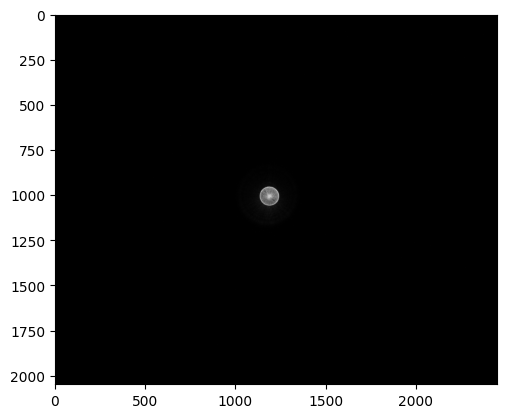

In [35]:
input_field = input_amplitude * np.exp(1j * estimated_input_phase)
output_field = propagate_to_far_field(input_field, wavelength, focal_length, input_pixel_size)
output_intensity = np.abs(output_field) ** 2
plt.imshow(output_intensity, cmap='gray')

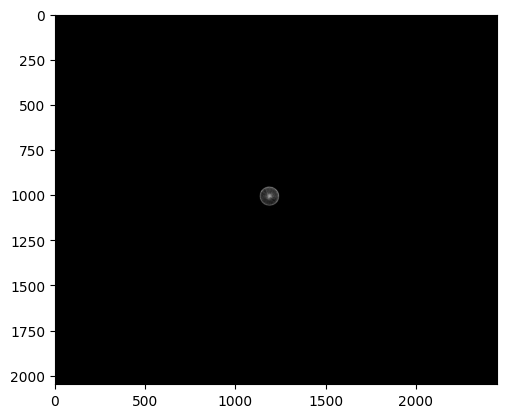

In [31]:
plt.imshow(normalization(output_intensity**2), cmap='gray')